In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def SimulatedAnnealing_V1(funcao, dominio, T0, T_min, alpha, noise, max_iter):
    x = np.random.uniform(dominio[:, 0], dominio[:, 1])
    funcao = funcao(x)
    best_sol, f_best = x.copy(), funcao

    while T0 > T_min:
        for _ in range(max_iter):
            x_perturbado = x + np.random.normal(0, noise, size=len(x)) # Perturbação ao redor de x
            x_perturbado = np.clip(x_perturbado, dominio[:, 0], dominio[:, 1])

            f_next = funcao(x_perturbado)
            delta = f_next - funcao

            if delta < 0 or np.random.rand() < np.exp(-delta/T0):
                x, funcao = x_perturbado, f_next # Atualiza os valores
                if funcao < best_sol:
                    best_sol, f_best = x.copy(), funcao
        T *=alpha

    return best_sol, f_best




In [5]:
def SimulatedAnnealing_V2(funcao, dominio, T0, T_min, alpha, noise, max_iter, intervalo):
    import time

    # solução inicial
    x = np.random.uniform(dominio[:, 0], dominio[:, 1])
    fx = funcao(x)
    best_sol, f_best = x.copy(), fx

    iteracao = 0
    tempo_start = time.time()

    while T0 > T_min and iteracao < max_iter:
        for _ in range(max_iter):
            iteracao += 1
            x_novo = x + np.random.normal(0, noise, size=len(x))
            x_novo = np.clip(x_novo, dominio[:, 0], dominio[:, 1])
            fx_novo = funcao(x_novo)

            delta = fx_novo - fx

            if delta < 0 or np.random.rand() < np.exp(-delta/T0):
                x, fx = x_novo, fx_novo
                if fx < f_best:
                    best_sol, f_best = x.copy(), fx
            
            # Bloco de Monitoramento
            if iteracao % intervalo == 0:
                passado = time.time() - tempo_start
                ips = iteracao / passado if passado > 0 else float("inf")
                print(f"[Iteração {iteracao}] T={T0:.4f}, Melhor valor={f_best:.4f}, IPS={ips:.2f}")

        # resfriamento
        T0 *= alpha

    
    return best_sol, f_best

In [6]:
def SimulatedAnnealing_V3(funcao, dominio, T0, T_min, alpha, noise, max_iter, intervalo, x0=None):
    import time

    
    # solução inicial
    if x0 is None:
        x = np.random.uniform(dominio[:, 0], dominio[:, 1])
    else:
        x = np.array(x0, dtype=float)
        x = np.clip(x, dominio[:, 0], dominio[:, 1])

    fx = funcao(x)
    best_sol, f_best = x.copy(), fx

    iteracao = 0
    tempo_start = time.time()
    historico = [x.copy()]

    while T0 > T_min and iteracao < max_iter:
        iteracao += 1
        x_novo = x + np.random.normal(0, noise, size=len(x))
        x_novo = np.clip(x_novo, dominio[:, 0], dominio[:, 1])
        fx_novo = funcao(x_novo)

        delta = fx_novo - fx

        if delta < 0 or np.random.rand() < np.exp(-delta/T0):
            x, fx = x_novo, fx_novo
            historico.append(x.copy())
            if fx < f_best:
                best_sol, f_best = x.copy(), fx

        if iteracao % intervalo == 0:
            passado = time.time() - tempo_start
            ips = iteracao / passado if passado > 0 else float("inf")
            print(f"[Iteração {iteracao}] T={T0:.4f}, Melhor valor={f_best:.4f}, IPS={ips:.2f}")

        T0 *= alpha

    historico = np.array(historico)

    # --- Plotagem do caminho ---
    if len(x) == 1:
        # Caso 1D
        X = np.linspace(dominio[0,0], dominio[0,1], 500)
        Y = np.array([funcao([xx]) for xx in X])
        plt.plot(X, Y, 'b-', label="Função")
        plt.plot(historico[:,0], [funcao(p) for p in historico], 'ro-', label="Caminho")
        plt.legend()
        plt.show()

    elif len(x) == 2:
        # Caso 2D
        X = np.linspace(dominio[0,0], dominio[0,1], 200)
        Y = np.linspace(dominio[1,0], dominio[1,1], 200)
        XX, YY = np.meshgrid(X, Y)
        Z = np.array([funcao([xx, yy]) for xx, yy in zip(XX.ravel(), YY.ravel())]).reshape(XX.shape)

        plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
        plt.plot(historico[:,0], historico[:,1], 'ro-', markersize=3, label="Caminho")
        plt.scatter(historico[0,0], historico[0,1], c="blue", marker="o", s=80, label="Início")
        plt.scatter(best_sol[0], best_sol[1], c="red", marker="*", s=120, label="Melhor")
        plt.legend()
        plt.colorbar(label="f(x)")
        plt.show()

    elif len(x) == 3:
        # Caso 3D (trajetória sobre a superfície)
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        X = np.linspace(dominio[0,0], dominio[0,1], 80)
        Y = np.linspace(dominio[1,0], dominio[1,1], 80)
        XX, YY = np.meshgrid(X, Y)
        Z = np.array([funcao([xx, yy, 0]) for xx, yy in zip(XX.ravel(), YY.ravel())]).reshape(XX.shape)

        ax.plot_surface(XX, YY, Z, cmap="viridis", alpha=0.6)
        hist_Z = np.array([funcao(p) for p in historico])
        ax.plot(historico[:,0], historico[:,1], hist_Z, 'r.-', label="Caminho")
        ax.scatter(best_sol[0], best_sol[1], f_best, c="red", marker="*", s=100, label="Melhor")
        plt.legend()
        plt.show()

    return best_sol, f_best

In [25]:
def EnxameDePartícula_V1(funcao, dim, dominio, num_particulas, max_iter, w, c1, c2):

    # Inicialização das partículas
    x = np.random.uniform(dominio[0], dominio[1], (num_particulas, dim))
    v = np.zeros((num_particulas, dim))

    pbest = x.copy()
    pbest_val = np.array([funcao(p) for p in pbest])
    gbest = pbest[np.argmin(pbest_val)]
    gbest_val = np.min(pbest_val)

    for i in range(max_iter):
        for j in range(num_particulas):

            #Atualização da velocidade das partículas
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            v[j] = (w * v[j] +
                    c1 * r1 * (pbest[j] - x[j]) +
                    c2 * r2 * (gbest - x[j]))
            
            #Atualização da posição

            x[j] = x[j] + v[j]
            x[j] = np.clip(x[j], dominio[0], dominio[1]) # Essa linha mantem as posições dentro do domínio de busca

            #Avaliação da função objetivo

            val = funcao(x[j])
            if val < pbest_val[j]:
                pbest[j], pbest_val[j] = x[j].copy(), val

        # Atualização gbest

        if np.min(pbest_val) < gbest_val:
            gbest, gbest_val, = pbest[np.argmin(pbest_val)], np.min(pbest_val)

        
        print(f'Iteração {i+1}, Melhor valor = {gbest_val:.6f}')

    return gbest, gbest_val

In [34]:
def EnxameDePartícula_V2(funcao, dim, dominio, num_particulas, max_iter, w, c1, c2):

    # Inicialização
    x = np.random.uniform(dominio[0], dominio[1], (num_particulas, dim))
    v = np.zeros((num_particulas, dim))
    pbest = x.copy()
    pbest_val = np.array([funcao(p) for p in pbest])
    gbest = pbest[np.argmin(pbest_val)]
    gbest_val = np.min(pbest_val)

    historico = [x.copy()]

    for it in range(max_iter):
        for i in range(num_particulas):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            v[i] = (w*v[i] + c1*r1*(pbest[i]-x[i]) + c2*r2*(gbest-x[i]))
            x[i] = x[i] + v[i]
            x[i] = np.clip(x[i], dominio[0], dominio[1])

            val = funcao(x[i])
            if val < pbest_val[i]:
                pbest[i], pbest_val[i] = x[i].copy(), val

        if np.min(pbest_val) < gbest_val:
            gbest, gbest_val = pbest[np.argmin(pbest_val)], np.min(pbest_val)

        historico.append(x.copy())
        print(f"Iteração {it+1}, Melhor valor = {gbest_val:.6f}")

    historico = np.array(historico)

    # --- Plot da função + partículas ---
    X = np.linspace(dominio[0], dominio[1], 200)
    Y = np.linspace(dominio[0], dominio[1], 200)
    XX, YY = np.meshgrid(X, Y)
    Z = np.array([funcao(np.array([xx, yy])) for xx, yy in zip(XX.ravel(), YY.ravel())]).reshape(XX.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(XX, YY, Z, levels=50, cmap='viridis')
    for it in range(len(historico)):
        plt.scatter(historico[it,:,0], historico[it,:,1], color='red', s=20, alpha=0.3)
    plt.scatter(gbest[0], gbest[1], color='blue', marker='*', s=200, label='Melhor')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('PSO: Trajetória das partículas na superfície da função')
    plt.colorbar(label='f(x)')
    plt.legend()
    plt.show()

    return gbest, gbest_val

# Funções de Benchmark

In [7]:
def rastrigin(x):
    """Função de teste em N dimensões"""
    A = 10
    x = np.array(x)
    return A*len(x) + np.sum(x**2 - A*np.cos(2*np.pi*x))

def sphere(x):
    return np.sum(x**2)

def ackley(x):
    a, b, c = 20, 0.2, 2*np.pi
    n = len(x)
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(c * x))
    return -a * np.exp(-b * np.sqrt(sum_sq / n)) - np.exp(sum_cos / n) + a + np.e

In [8]:
N = 5
bounds = np.array([[-5.12]*N, [5.12]*N]).T

best, val = SimulatedAnnealing_V2(rastrigin, bounds, T0=1000, T_min=1e-6, alpha=0.6, noise=0.02, max_iter=10_000, intervalo=10)
print("Melhor solução encontrada:", best)
print("Valor da função:", val)

[Iteração 10] T=1000.0000, Melhor valor=59.3721, IPS=28225.46
[Iteração 20] T=1000.0000, Melhor valor=49.7739, IPS=27767.65
[Iteração 30] T=1000.0000, Melhor valor=49.7739, IPS=33438.51
[Iteração 40] T=1000.0000, Melhor valor=49.7739, IPS=35394.97
[Iteração 50] T=1000.0000, Melhor valor=44.9168, IPS=37078.36
[Iteração 60] T=1000.0000, Melhor valor=34.4711, IPS=39488.19
[Iteração 70] T=1000.0000, Melhor valor=34.4711, IPS=41758.11
[Iteração 80] T=1000.0000, Melhor valor=34.4711, IPS=40441.64
[Iteração 90] T=1000.0000, Melhor valor=34.4711, IPS=41669.87
[Iteração 100] T=1000.0000, Melhor valor=32.4560, IPS=42978.83
[Iteração 110] T=1000.0000, Melhor valor=31.8268, IPS=44146.34
[Iteração 120] T=1000.0000, Melhor valor=31.7841, IPS=45197.24
[Iteração 130] T=1000.0000, Melhor valor=31.7841, IPS=46173.22
[Iteração 140] T=1000.0000, Melhor valor=31.7841, IPS=47081.67
[Iteração 150] T=1000.0000, Melhor valor=31.7841, IPS=48033.72
[Iteração 160] T=1000.0000, Melhor valor=31.7841, IPS=49265.06
[

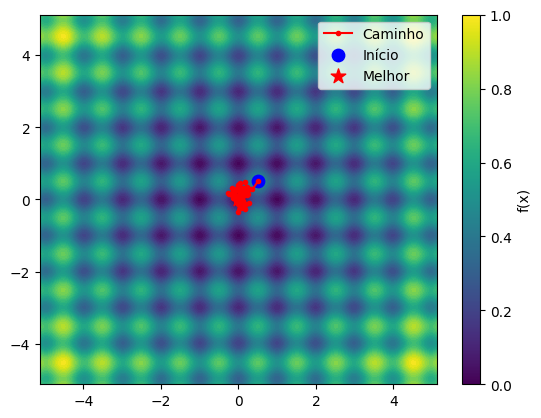

Melhor solução encontrada: [-0.00089857  0.00604216]
Valor da função: 0.00740216896117829


In [17]:
N = 2
bounds = np.array([[-5.12]*N, [5.12]*N]).T

best, val = SimulatedAnnealing_V3(
    rastrigin, bounds,
    T0=1000, T_min=1e-6, alpha=0.9, noise=0.1,
    max_iter=20000, intervalo=1_000,
    x0=[0.5, 0.5]   )

print("Melhor solução encontrada:", best)
print("Valor da função:", val)

In [ ]:
dim = 2
bounds = [-5, 5]
best, val = EnxameDePartícula_V1(sphere, dim, bounds, num_particulas=30, max_iter=50, w=0.7, c1=1.5, c2=1.5)
print("Melhor solução encontrada:", best)
print("Valor da função:", val)

Iteração 1, Melhor valor = 0.131384
Iteração 2, Melhor valor = 0.014691
Iteração 3, Melhor valor = 0.014691
Iteração 4, Melhor valor = 0.006255
Iteração 5, Melhor valor = 0.006255
Iteração 6, Melhor valor = 0.004734
Iteração 7, Melhor valor = 0.004734
Iteração 8, Melhor valor = 0.002136
Iteração 9, Melhor valor = 0.002136
Iteração 10, Melhor valor = 0.002136
Iteração 11, Melhor valor = 0.002136
Iteração 12, Melhor valor = 0.002136
Iteração 13, Melhor valor = 0.002136
Iteração 14, Melhor valor = 0.001929
Iteração 15, Melhor valor = 0.000111
Iteração 16, Melhor valor = 0.000111
Iteração 17, Melhor valor = 0.000111
Iteração 18, Melhor valor = 0.000111
Iteração 19, Melhor valor = 0.000111
Iteração 20, Melhor valor = 0.000111
Iteração 21, Melhor valor = 0.000060
Iteração 22, Melhor valor = 0.000060
Iteração 23, Melhor valor = 0.000019
Iteração 24, Melhor valor = 0.000019
Iteração 25, Melhor valor = 0.000019
Iteração 26, Melhor valor = 0.000019
Iteração 27, Melhor valor = 0.000003
Iteração 2

Iteração 1, Melhor valor = 2.217639
Iteração 2, Melhor valor = 2.217639
Iteração 3, Melhor valor = 2.217639
Iteração 4, Melhor valor = 2.217639
Iteração 5, Melhor valor = 2.217639
Iteração 6, Melhor valor = 2.181985
Iteração 7, Melhor valor = 2.181985
Iteração 8, Melhor valor = 2.181985
Iteração 9, Melhor valor = 1.427527
Iteração 10, Melhor valor = 1.427527
Iteração 11, Melhor valor = 1.427527
Iteração 12, Melhor valor = 1.427527
Iteração 13, Melhor valor = 1.427527
Iteração 14, Melhor valor = 1.427527
Iteração 15, Melhor valor = 1.145096
Iteração 16, Melhor valor = 1.145096
Iteração 17, Melhor valor = 1.145096
Iteração 18, Melhor valor = 0.149325
Iteração 19, Melhor valor = 0.149325
Iteração 20, Melhor valor = 0.149325
Iteração 21, Melhor valor = 0.023801
Iteração 22, Melhor valor = 0.023801
Iteração 23, Melhor valor = 0.023801
Iteração 24, Melhor valor = 0.023801
Iteração 25, Melhor valor = 0.023801
Iteração 26, Melhor valor = 0.023801
Iteração 27, Melhor valor = 0.023801
Iteração 2

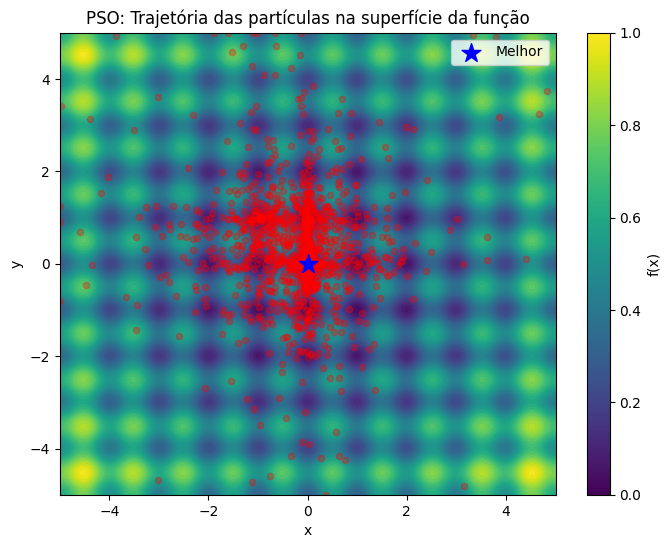

Melhor solução encontrada: [-0.00113847 -0.00011008]
Valor da função: 0.0002595430929730469


In [36]:
dim = 2
bounds = [-5, 5]
best, val = EnxameDePartícula_V2(rastrigin, dim, bounds, num_particulas=30, max_iter=50, w=0.7, c1=1.5, c2=1.5)
print("Melhor solução encontrada:", best)
print("Valor da função:", val)